<a href="https://colab.research.google.com/github/guru3/hand_sign_detector/blob/master/1.%20Train%20a%20model%20to%20detect%20sign%20language%20using%20MNIST%20dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Let's give it another shot!

In [0]:
! pip install -q kaggle
from google.colab import files
files.upload()

In [0]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download datamunge/sign-language-mnist
!unzip sign-language-mnist.zip

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
import csv
import random
import pickle
import string
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.utils import to_categorical
from keras import backend as kbackend
from keras.callbacks import Callback
from keras.models import Sequential,Model
from keras.layers import Conv2D,Dense,Flatten,Input,Dropout
import create_model_for_mnist as modelGen
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [0]:
def label_to_character( label ):
  return chr(ord('A') + int(label));

def one_hot_vector_to_character( vector ):
  charac = np.argmax(vector);
  return label_to_character( charac );

In [3]:
fil = csv.reader( open('./sign_mnist_train.csv','r') );
next(fil);
map = {}
for line in fil:
  map[line[0]] = 1;
unique = [ label_to_character(x) for x in map.keys() ]
unique.sort();
print( unique  );

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']


In [0]:
total_signs = 25;

In [0]:
def read_file( file, split=False ):
  csv_reader = csv.reader( open( file, 'r' ) );
  next(csv_reader);
  data = [];
  Y = [];
  for line in csv_reader:
    line = [ int(x) for x in line ];
    Y.append( to_categorical(line[0], total_signs ) );
    data.append( np.array(line[1:]).reshape(28,28,1) );
  
  if( split ):
    totalTrainingEx = int(len(data)*0.9);
    return np.array(data[0:totalTrainingEx])/255., np.array(Y[0:totalTrainingEx]), \
      np.array(data[totalTrainingEx:])/255, np.array(Y[totalTrainingEx:])
  else:
    return np.array(data)/255, np.array(Y)

In [0]:
Xtrain, Ytrain, XValid, YValid = read_file('./sign_mnist_train.csv', split=True);
Xtest, Ytest = read_file('./sign_mnist_test.csv');

In [7]:
print( 'Training data shape:\t', Xtrain.shape, Ytrain.shape );
print( 'Validation data shape:\t', XValid.shape, YValid.shape );
print( 'Testing data shape:\t', Xtest.shape, Ytest.shape );

Training data shape:	 (24709, 28, 28, 1) (24709, 25)
Validation data shape:	 (2746, 28, 28, 1) (2746, 25)
Testing data shape:	 (7172, 28, 28, 1) (7172, 25)


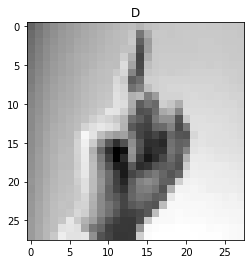

In [8]:
_ = plt.imshow( Xtrain[0].reshape(28,28), cmap='gray' )
_ = plt.title( one_hot_vector_to_character(Ytrain[0]) )

In [9]:
model = modelGen.get_model()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 27, 27, 128)       640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 64)        32832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 64)        16448     
_________________________________________________________________
flatten_1 (Flatten)          (None, 40000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               20480512  
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)              

In [0]:
datagen = ImageDataGenerator( zoom_range = 0.1, width_shift_range=0.1, height_shift_range=0.1) 
datagen.fit(Xtrain)

In [11]:
history = model.fit( datagen.flow(Xtrain,Ytrain, batch_size = 64), epochs=50, validation_data=(XValid,YValid) );

Epoch 1/50
387/387 [==============================] - 19s 50ms/step - loss: 2.4276 - accuracy: 0.2618 - val_loss: 0.9714 - val_accuracy: 0.7094
Epoch 2/50
387/387 [==============================] - 18s 45ms/step - loss: 1.1806 - accuracy: 0.6061 - val_loss: 0.2796 - val_accuracy: 0.9162
Epoch 3/50
387/387 [==============================] - 17s 45ms/step - loss: 0.6564 - accuracy: 0.7808 - val_loss: 0.0976 - val_accuracy: 0.9785
Epoch 4/50
387/387 [==============================] - 17s 45ms/step - loss: 0.4461 - accuracy: 0.8496 - val_loss: 0.0613 - val_accuracy: 0.9865
Epoch 5/50
387/387 [==============================] - 17s 45ms/step - loss: 0.3152 - accuracy: 0.8965 - val_loss: 0.0313 - val_accuracy: 0.9924
Epoch 6/50
387/387 [==============================] - 17s 45ms/step - loss: 0.2537 - accuracy: 0.9128 - val_loss: 0.0133 - val_accuracy: 0.9975
Epoch 7/50
387/387 [==============================] - 17s 45ms/step - loss: 0.2014 - accuracy: 0.9339 - val_loss: 0.0080 - val_accuracy:

In [12]:
predictedChar = [label_to_character( x ) for x in model.predict_classes(Xtrain)]
actualChar = [one_hot_vector_to_character( x ) for x in Ytrain]
sumI = 0;
for i in range(len(predictedChar)):
  sumI = sumI + (actualChar[i] == predictedChar[i] )
print('Test accuracy is', sumI/len(predictedChar));

Test accuracy is 1.0


In [0]:
model.save_weights('./drive/My Drive/Colab Notebooks/mnist-handsign-weights.hdf5');